
## Refolded folds
This example recreates the model from Laurent et al., 2016 and applied the fold geostatistics tools introduced by Grose et al., 2017. To run this example you need:
* LoopStructural
* matplotlib
* lavavu

If you are on google colab or don't have these installed uncomment the following line

In [1]:
#!pip install LoopStructural matplotlib lavavu

In [2]:
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer, RotationAnglePlotter
from LoopStructural.datasets import load_laurent2016
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# load in the data from the provided examples
data, bb = load_laurent2016()
data.head()

newdata = pd.DataFrame([[5923.504395,4748.135254,3588.621094,'s2',1.0]],columns=['X','Y','Z','feature_name','val'])
data = pd.concat([data,newdata],sort=False)
data.loc[np.logical_and(data['feature_name'] == 's2',np.isnan(data['nx'])),'feature_name'] ='s21'
data.loc[np.logical_and(data['feature_name'] == 's0',~np.isnan(data['val'])),'feature_name'] = 's01'

rotation = [-69.11979675292969, 15.704944610595703, 6.00014591217041]

In [3]:
images = []

Building the most recent fold frame S2 using observations of the axial foliation. Because the folds we are modelling are cylindrical we do not need to define the entire fold frame and can use only the axial foliation. LoopStructural will provide a warning to say that coordinate 1 and 2 cannot be built. 

2021-04-09 15:38:50,399 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for structural frame coordinate 1, 
Add some more and try again.
2021-04-09 15:38:50,399 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for structural frame coordinate 1, 
Add some more and try again.
2021-04-09 15:38:50,400 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for fold frame coordinate 1, 
Add some more and try again.
2021-04-09 15:38:50,400 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for fold frame coordinate 1, 
Add some more and try again.



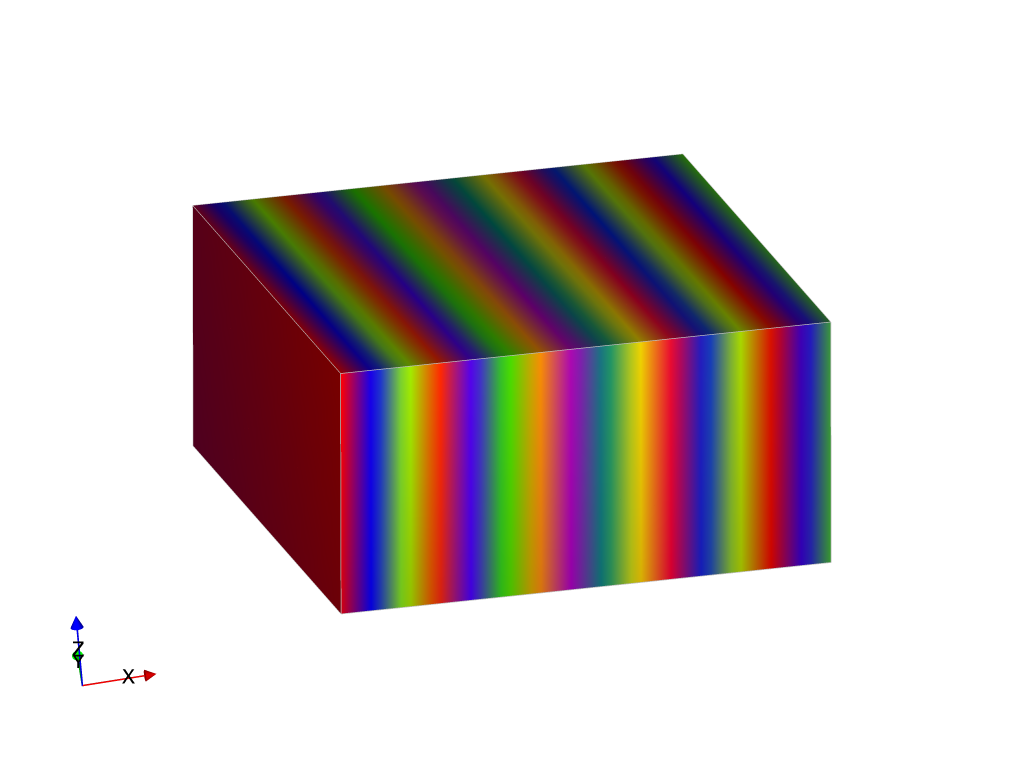

In [4]:
model = GeologicalModel(bb[0,:],bb[1,:])
model.set_model_data(data)
s2 = model.create_and_add_fold_frame('s2',
                                     nelements=1e5, 
                                     buffer=0.5,
                                    solver='lu',
                                    damp=True)
viewer = LavaVuModelViewer(model)
viewer.add_scalar_field(s2[0],
                       cmap='prism')
viewer.add_isosurface(s2[0],
                     slices=[0,1])
viewer.add_data(s2[0])
viewer.rotate(rotation)
viewer.display()
images.append(viewer.image_array())

Model the fold frame for F1 using the observations of S1. The fold is cylindrial and we have not defined the fold axis direction field so the fold axis is calculated using the average fold axis method (`av_fold_axis`). The `lu` solver is used here, it is important not to use `pyamg` when modelling folds as the results can be erroneous due to the way the algorithmic multigrid solver tried to simplify the linear system. 


In [5]:
s1 = model.create_and_add_folded_fold_frame('s1',
                                            limb_wl=8, 
                                            av_fold_axis=True,
                                            nelements=5e4,
                                            buffer=0.3,
                                            solver='lu'
                                           )





2021-04-09 15:42:41,192 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for structural frame coordinate 1, 
Add some more and try again.
2021-04-09 15:42:41,192 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for structural frame coordinate 1, 
Add some more and try again.
2021-04-09 15:42:41,193 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for fold frame coordinate 1, 
Add some more and try again.
2021-04-09 15:42:41,193 ~ LoopStructural.modelling.features.structural_frame_builder ~ WARNING    ~ Not enough constraints for fold frame coordinate 1, 
Add some more and try again.



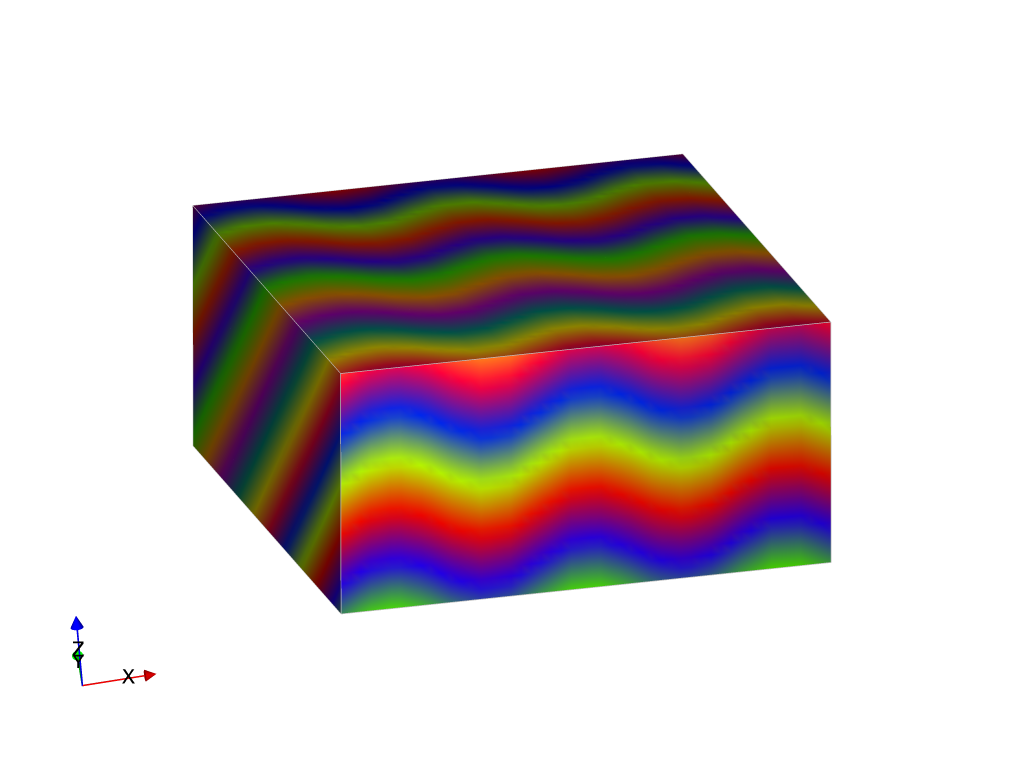

In [6]:
viewer = LavaVuModelViewer(model)
viewer.add_scalar_field(s1[0],
                       cmap='prism')
viewer.add_isosurface(s1[0],nslices=5)
# viewer.add_fold(s1.fold)
viewer.add_data(s1[0])
# viewer.add_points(s1[0].interpolator.support.nodes,'nodes')
viewer.rotate([-69.11979675292969, 15.704944610595703, 6.00014591217041])
viewer.display()
images.append(viewer.image_array())

Visualise the fold geometry using the S-Plot of S2/S1. The fold hinges are marked with dashed vertical lines.




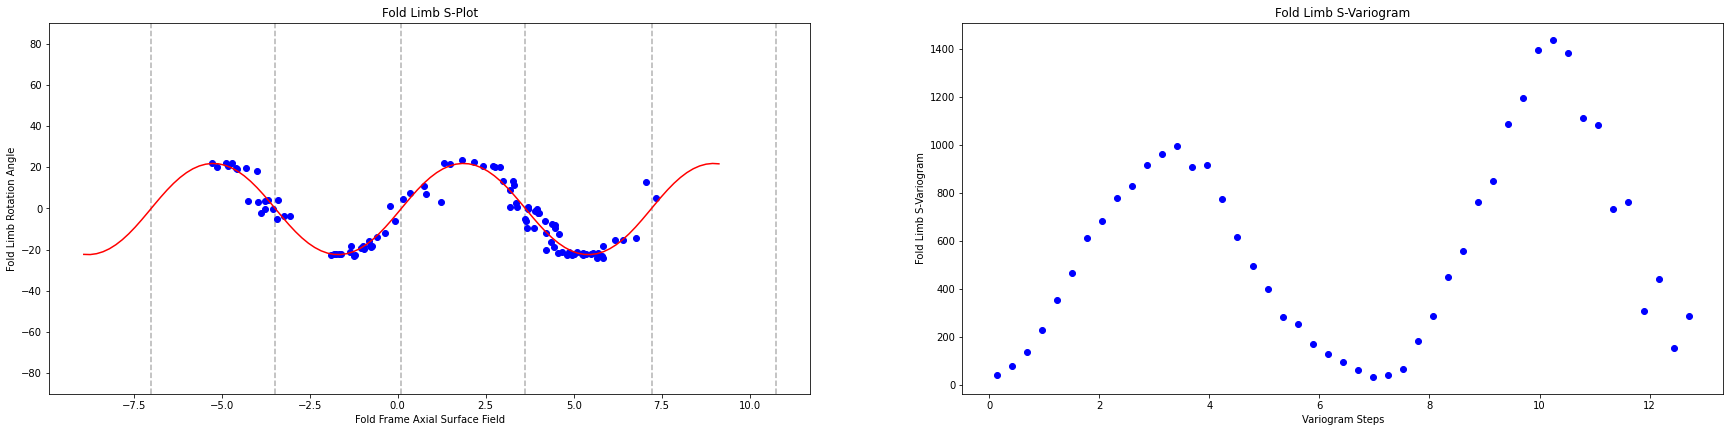

In [10]:
s1.fold.foldframe[0].set_model(model)
# s1.fold.foldframe[1].set_model(model)

s2_s1_splot = RotationAnglePlotter(s1)
s2_s1_splot.add_fold_limb_data()
s2_s1_splot.add_fold_limb_curve() 
s2_s1_splot.add_limb_svariogram()#fold_limb_
s2_s1_splot.default_titles()
s2_s1_splot.fig.delaxes(s2_s1_splot.ax[0][0])
s2_s1_splot.fig.delaxes(s2_s1_splot.ax[0][1])

roots = model['s1'].fold.fold_limb_rotation.find_hinges([model['s2'][0].min(),model['s2'][0].max()],3.5)
lines = s2_s1_splot.ax[1][0].vlines(roots,np.zeros(len(roots))-90,np.zeros(len(roots))+90,linestyle='dashed',color='black',alpha=0.3)

Modelling S0
~~~~~~~~~~~~




S0 is modelled using the S1 fold frame. It is also modelled as cylindrical.

In [11]:
s0 = model.create_and_add_folded_foliation('s0',
                                           fold_frame=s1,
                                            limb_wl=1., 
                                            av_fold_axis=True,
                                            nelements=5e4,
                                            buffer=0.2,
                                           solver='lu'
                                           )



Use contact information to determine isosurfaces

In [12]:
traces = data.loc[data['feature_name']=='s01',['X','Y','Z','val']].to_numpy()
unique = np.unique(traces[:,3])
vals = []
for u in unique:
    vals.append(np.mean(model['s0'].evaluate_value(model.scale(traces[traces[:,3]==u,:3],inplace=False))))
              


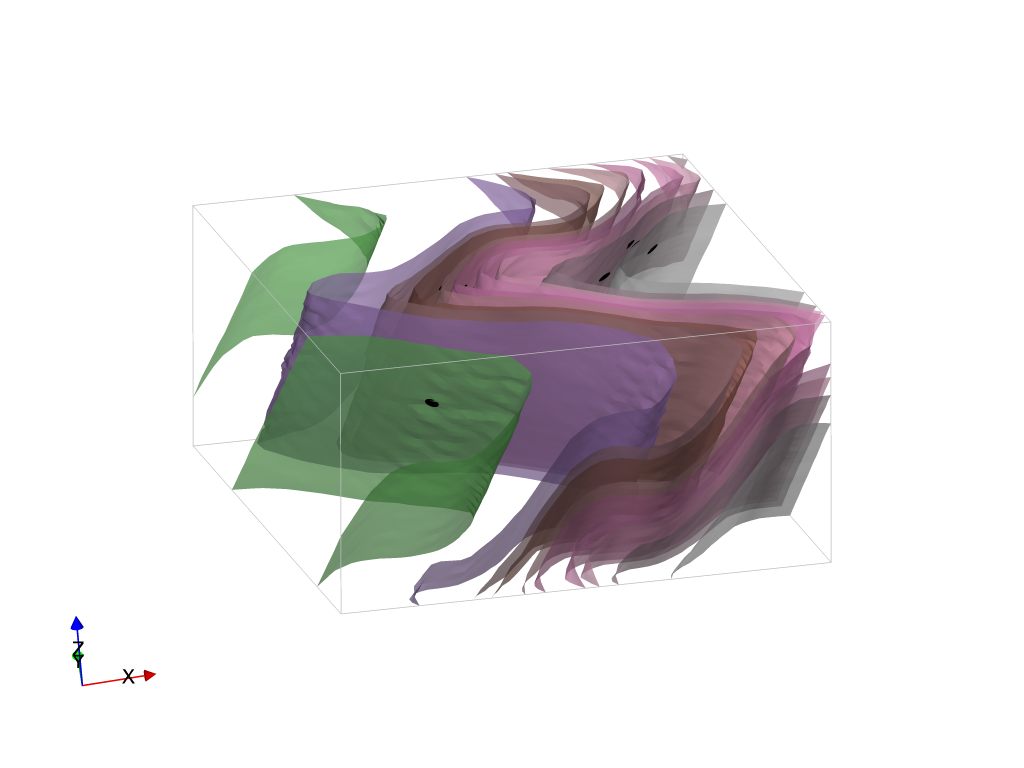

In [14]:
viewer = LavaVuModelViewer(model)

viewer.add_isosurface(s0,
                     slices=vals,
                     paint_with=s0,
                      cmap='tab20',
                     opacity=0.7)
viewer.add_data(s0,cmap='tab20')

viewer.rotate([-69.11979675292969, 15.704944610595703, 6.00014591217041])
# viewer.interactive()
viewer.display()
images.append(viewer.image_array())

Text(0.5, 1.0, 'C. S0 geological model')

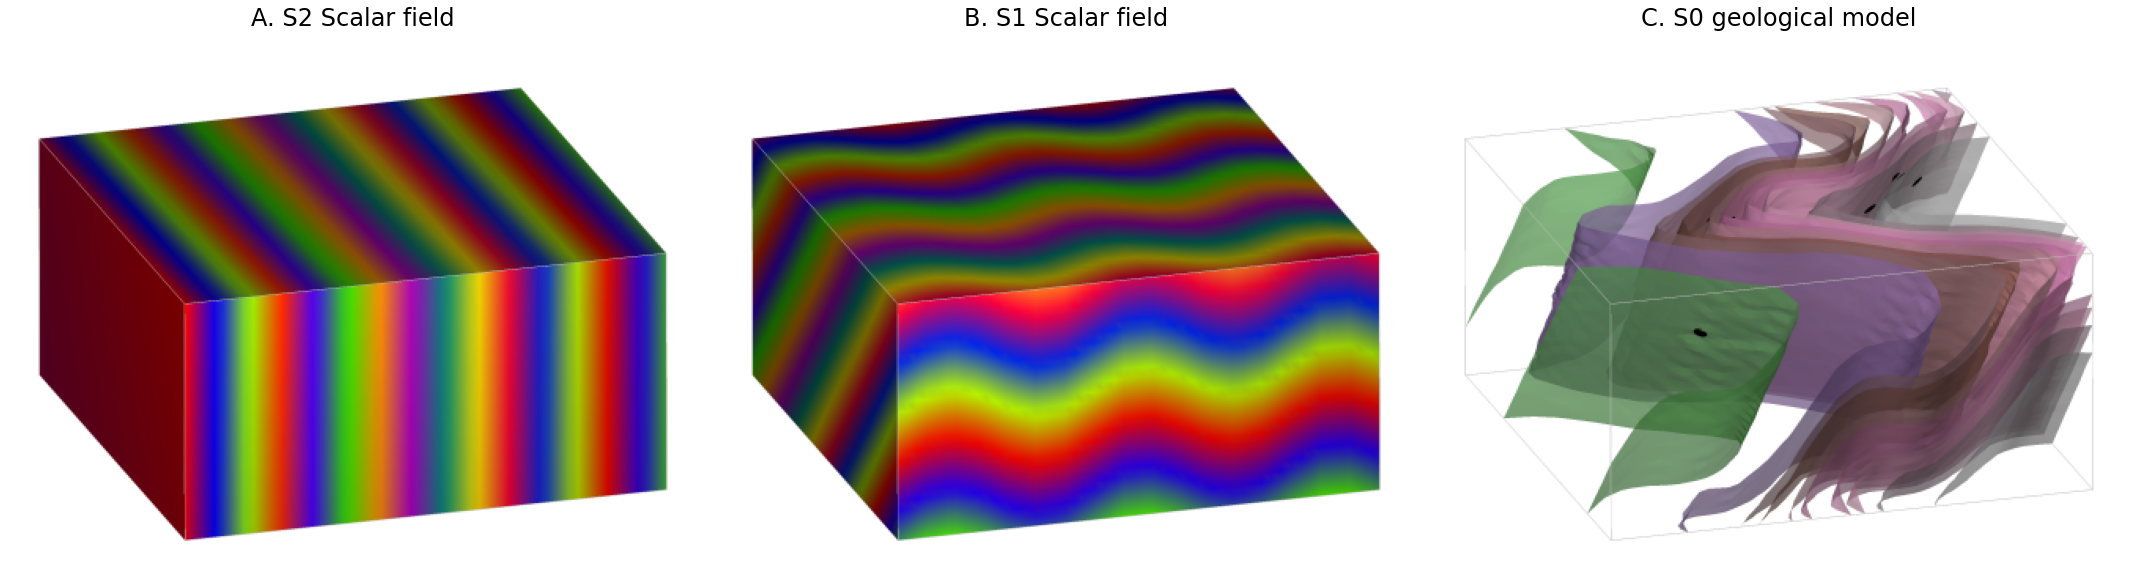

In [15]:
from matplotlib import rcParams

rcParams['font.size'] = 20
fig, ax = plt.subplots(1,3,figsize=(30,10))
ax[0].imshow(images[0][60:400,100:540])
ax[1].imshow(images[1][60:400,100:540])
ax[2].imshow(images[-1][60:400,100:540])
for i in range(3):
    ax[i].axis('off')
plt.tight_layout()
ax[0].set_title('A. S2 Scalar field')
ax[1].set_title('B. S1 Scalar field')
ax[2].set_title('C. S0 geological model')

S-Plot of S1/S0




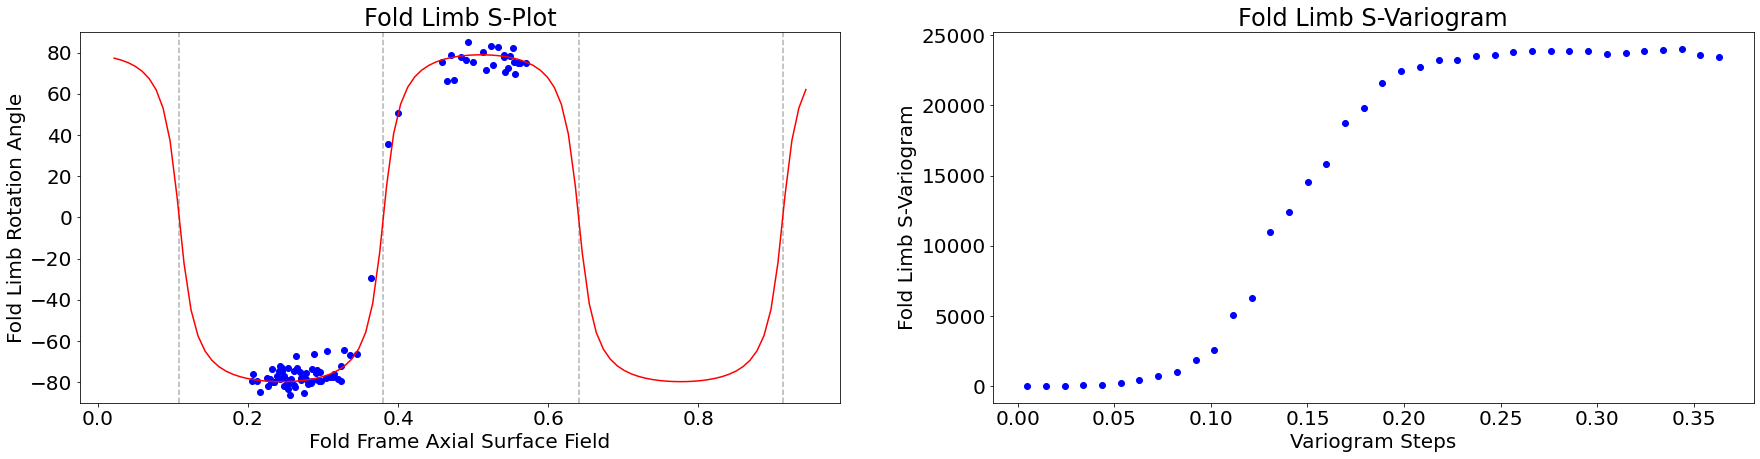

In [18]:
s0.fold.foldframe[0].set_model(model)
# s1.fold.foldframe[1].set_model(model)

s1_s0_splot = RotationAnglePlotter(s0)
s1_s0_splot.add_fold_limb_data()
s1_s0_splot.add_fold_limb_curve() 
s1_s0_splot.add_limb_svariogram()#fold_limb_
s1_s0_splot.default_titles()
s1_s0_splot.fig.delaxes(s1_s0_splot.ax[0][0])
s1_s0_splot.fig.delaxes(s1_s0_splot.ax[0][1])

roots2 = model['s0'].fold.fold_limb_rotation.find_hinges([model['s1'][0].min(),model['s1'][0].max()],.25)
s1_s0_splot.ax[1][0].vlines(roots2,np.zeros(len(roots2))-90,np.zeros(len(roots2))+90,linestyle='dashed',color='black',alpha=0.3)


## Export to html
The code below creates a lavavu object that contains all of the created features. It is then exported to a html file.

2021-04-09 15:46:28,678 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-09 15:46:28,678 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-09 15:46:28,678 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box



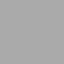

In [19]:
view = LavaVuModelViewer(model)
view.add_isosurface(model['s0'],slices=vals,paint_with=s0,cmap='tab20')
view.add_data(model['s0'])
view.add_data(model['s1'][0])
view.add_data(model['s2'][0])
view.add_isosurface(model['s1'][0],slices=roots2,paint_with=s1[0],cmap='rainbow')
view.add_isosurface(model['s2'][0],slices=roots,paint_with=s2[0],cmap='rainbow')
# view.interactive()

view.interactive()
view.export_to_webgl('fold_model')